# Visualisation of the DynAstVO database

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from packages.dataCleaner import cleanData
from packages.chunkReader import readByChunks, concatenate

## Cleaning the data file

The raw file contains Optical, Spatial and Radar observations, which are written in the text file using different formats. We need to clean this file in order to work with the data. We split the file into 2 distinct files, suppressing every useless line of data (object header and the position of a satellite in the case of spatial observation)

In [5]:
INPUT_FILE = 'Data\\OMC20200621.txt'
OPTICAL_SPACE_OUTPUT_FILE = 'Data\\OpticalSpaceData.txt'
RADAR_OUTPUT_FILE = 'Data\\RadarData.txt'

cleanData(INPUT_FILE, OPTICAL_SPACE_OUTPUT_FILE, RADAR_OUTPUT_FILE)

2571320it [00:12, 203966.28it/s]


## Reading the data

### Optical and Spatial data

Firstly, we give a name to every column (cf documentation), and we read the file, previously separated according to the type of observation.
We start with the optical and spatial observations together in the same Dataframe because they have the same format.

In [6]:

OScolnames = {'obs_type': 'category',
              'measure_type': 'category',
              'year': np.uint16,
              'month': np.uint8,
              'day': np.float64,
              'RA': np.float64,
              'DEC': np.float64,
              'obs_code': 'category',
              'RA_bias_correction': np.float32,
              'DEC_bias_correction': np.float32,
              'RA_weight': np.float64,
              'DEC_weight': np.float64,
              'acceptance': 'bool',
              'catalog': 'category',
              'mag': np.float64,
              'nbr_obs': np.float16,
              'random_number': np.float64,
              'RA_delta': np.float64,
              'DEC_delta': np.float64,
              'xhi_square': np.float64,
              'mag_acceptance': np.float16,
              'mag_delta': np.float64,
              'object_number': 'category'}
LINES_PER_CHUNK = 100000
OSdata = readByChunks("Data\\OpticalSpaceData.txt", OScolnames, LINES_PER_CHUNK)


In [7]:
from packages.catalogCodes import catalog_codes
OSdata = OSdata.replace({'catalog':catalog_codes})

### Radar Data

We repeat this step for the Radar data, which uses a different format.

In [8]:
RadarColnames = {'obs_type': 'category',
                 'measure_type': 'category',
                 'year': np.uint16,
                 'month': np.uint8,
                 'day': np.float64,
                 'Distance/Velocity': np.float64,
                 'c': 'category',
                 'obs_code_tr': 'category',
                 'obs_code_rc': 'category',
                 'bias_correction': np.float32,
                 'precision': np.float64,
                 'acceptance': 'bool',
                 'RA_delta': np.float64,
                 'xhi_square': np.float64,
                 'object_number': 'category'}

Rdata = readByChunks("Data\\RadarData.txt", RadarColnames, LINES_PER_CHUNK)

## Most important observatories

Some observatories are publishing a lot more data than others, and so are more reliable. Let's try to visualise which observatories are the most important by ploting the number of observations per observatory.

In [9]:
N_OBS = 20
BEST_OBS_LIST = list(OSdata['obs_code'].value_counts().head(N_OBS).index)

[Text(0, 0.5, 'Total number of observations'),
 Text(0.5, 0, 'Observatory code'),
 Text(0.5, 1.0, 'Number of observations by the 20 most active observatories')]

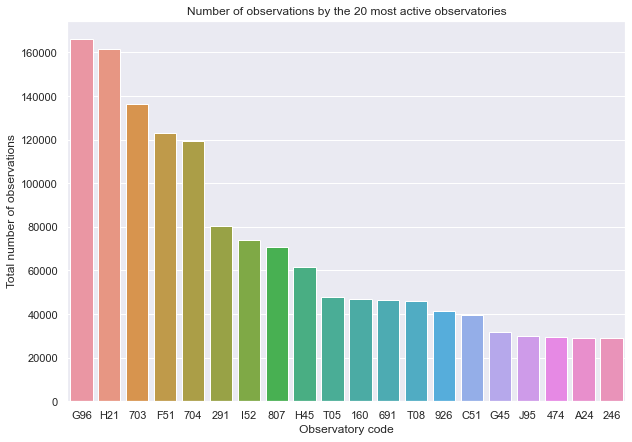

In [10]:
# plot the number of observations for the 20 bigest observatories
plt.figure(figsize=(10,7))
ax = sns.countplot(x='obs_code', data=OSdata, order=BEST_OBS_LIST)
ax.set(xlabel='Observatory code', ylabel='Total number of observations', title=f'Number of observations by the {N_OBS} most active observatories')

We can notice that the observatory G96 is the greatest contributor. This code corresponds to the Mt. Lemmon Survey observatory, a subsidiary of the Catalina Space Survey, ranked 3rd. The second greatest contributor, H21, is the Astronomical Research Observatory, Westfield. F51 corresponds to the PAN-STARSS sky survey in Hawaï The full list can be found here https://minorplanetcenter.net/iau/lists/ObsCodesF.html 

## Precision over time

With hardware improvements and new software, we can expect the precision of the observations to be better over time. We will verify this assumption for the best observatories.

### Study of the precision weight applied for the fitting process, for best observatories combined

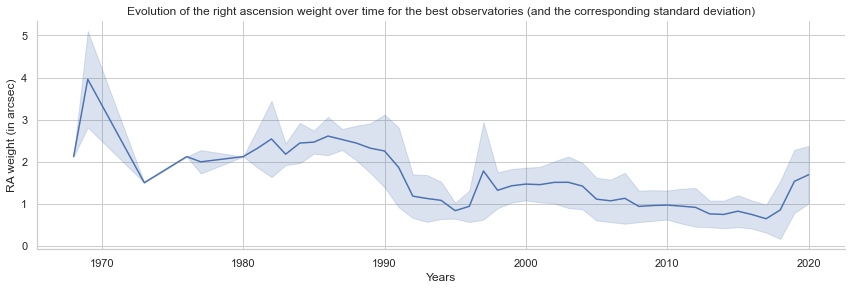

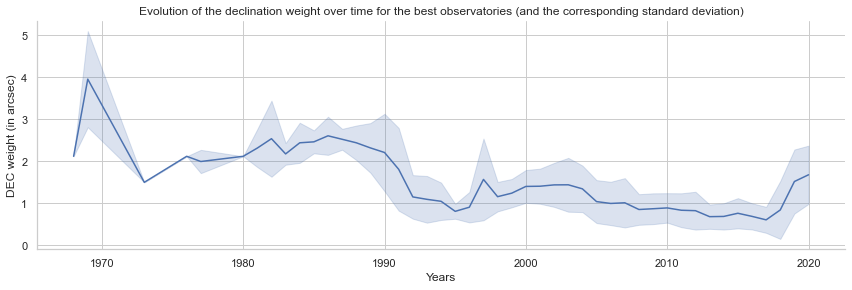

In [11]:
sns.set_style('whitegrid')
ax = sns.relplot(x='year', y='RA_weight', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension weight over time for the best observatories (and the corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_weight', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination weight over time for the best observatories (and the corresponding standard deviation)')


### Evolution of the precision weight over time for the 5 best observatories 

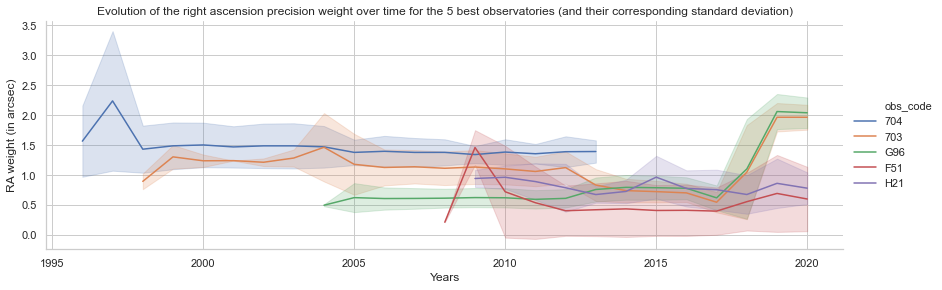

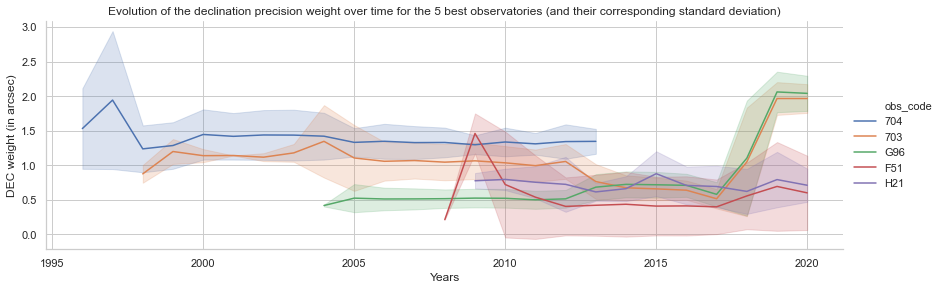

In [12]:
ax = sns.relplot(x='year', y='RA_weight', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 1995)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension precision weight over time for the 5 best observatories (and their corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_weight', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 1995)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination precision weight over time for the 5 best observatories (and their corresponding standard deviation)')


We can notice a strange augmentation of the precision weight since 2017, date of GAIA's entry into service. We expected a reduction of the precision weight for the observation made with GAIA's star catalogs (codes U and V), so this result may show a problem in the implementation of the fiting process. A theory is that the DynAstVO database, realized before GAIA results were published, does not take into account the new star catalogs introduced by GAIA, and so treats all the observations with the codes U and V like catalog-less observation, thus applying a bad precision weight.
However, GAIA's catalogs having the best precision currently available, this should be corrected to obtain a better overall precision.

Let's verify this assumption by comparing the average weight given to GAIA with the average weight given to every other star catalog as well as the non-referenced catalogs. We make sure to take into account only the observations accepted into the fitting process.

In [13]:
print("Mean of RA_weight for every catalog (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'] != 'U') & (OSdata['catalog'] != 'V') & (OSdata['year'] >= 2018)  & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for GAIA catalogs (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'] == 'U') | (OSdata['catalog'] == 'V') & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for non-referenced catalogs (2018-2020): ", OSdata['RA_weight'][(OSdata['catalog'].isnull()) & (OSdata['year'] >= 2018) & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())

Mean of RA_weight for every catalog (2018-2020):  1.3185930949946556
Mean of RA_weight for GAIA catalogs (2018-2020):  nan
Mean of RA_weight for non-referenced catalogs (2018-2020):  2.048290598290598


This shows that the GAIA catalogs, supposedly the most precise, are in fact not being recognized for their value in the fitting process.

### Study of the RA_Delta and DEC_Delta in function of time

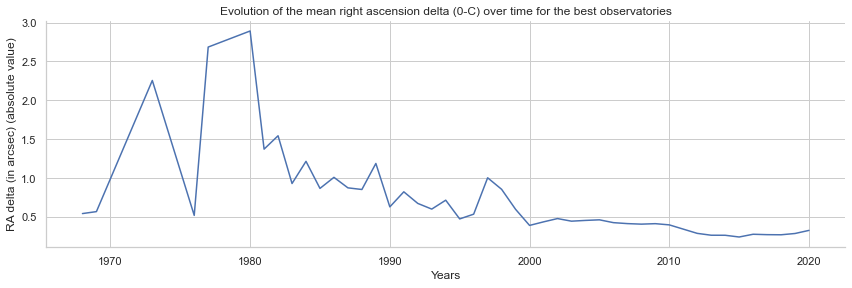

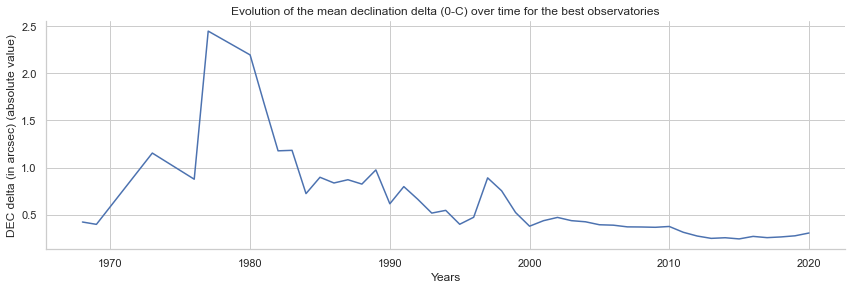

In [14]:
OSdata['RA_delta'] = OSdata['RA_delta'].abs()
ax = sns.relplot(x='year', y='RA_delta', kind="line", ci=None, data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA delta (in arcsec) (absolute value)', title='Evolution of the mean right ascension delta (0-C) over time for the best observatories')

OSdata['DEC_delta'] = OSdata['DEC_delta'].abs()
ax = sns.relplot(x='year', y='DEC_delta', kind="line", ci=None, data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC delta (in arcsec) (absolute value)', title='Evolution of the mean declination delta (0-C) over time for the best observatories')

As we can see on the graphs above, since 1990 and the widespread use of CCDs, the accuracy of measurements improved a lot. But we see few progress since 2000, with a delta of approx 0.2 arcsec. However, we can notice a slight increase since 2018, which i think is due to the "Gaia Bug" seen earlier. With the accuracy of Gaia star catalogs we should expect a reduction of the delta for both Right Ascension and Declination.

## Number of observations per year 

In [15]:
N_CAT = 15
MOST_USED_CATALOGS = list(OSdata['catalog'].value_counts().head(N_CAT).index)
print(MOST_USED_CATALOGS)

['UCAC-4', 'USNO-B1.0', 'USNO-A2.0', 'UCAC-2', 'Gaia-DR2', 'UCAC-3', 'Gaia-DR1', '2MASS', 'PPMXL', 'USNO-SA2.0', 'SST-RC4', 'GSC(version unspecified)', 'NOMAD', 'GSC-ACT', 'USNO-A1.0']


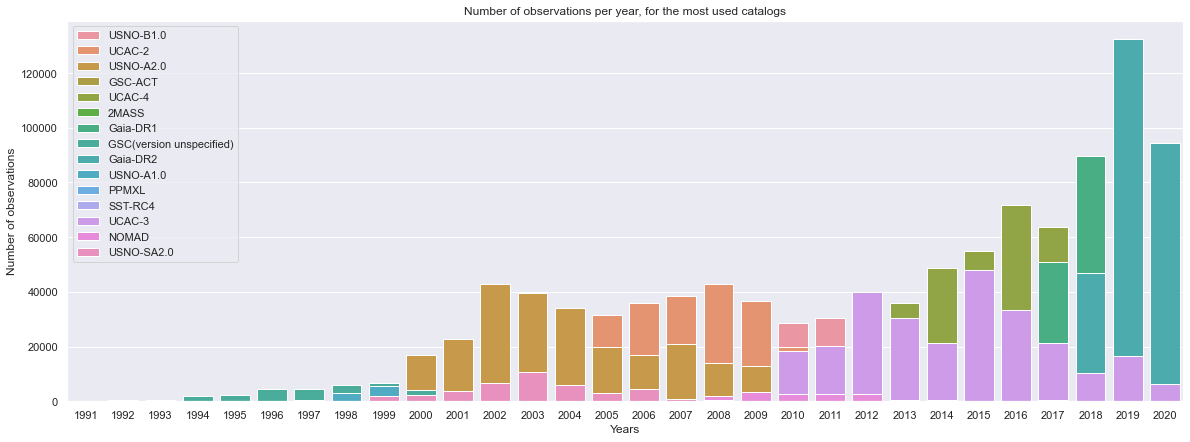

In [16]:
plt.figure(figsize=(20,7))
sns.set(rc={"axes.grid":True})
ax = sns.countplot(x='year', data=OSdata[(OSdata['year'] > 1990) & (OSdata['catalog'].isin(MOST_USED_CATALOGS))], hue='catalog', dodge=False)
ax.set(xlabel='Years', ylabel='Number of observations', title='Number of observations per year, for the most used catalogs')
plt.legend(loc='upper left')

As we can see on the previous graph, the introduction of the GAIA star catalogs in 2017 for Gaia-DR1 and 2018 for Gaia-DR2 is very noticable. Those two catalogs became the norm due to their very high precison, with only a few observations associated with UCAC-3 which was the most used catalog in the 2010s.
In 6 months, 2020 already gathered more observations than the full year of 2018.

The very high number of observations made with the Gaia catalogs should result in an increase in precision.